# Sad songs<a name="top"></a>

This is a replication of the [fitteR happieR](http://rcharlie.com/2017-02-16-fitteR-happieR/) post which attempted to find the most depressing Radiohead song.

I've redone it here, using tools available in TM351.

I'm also on a bit of a Beatles jag, so I've also done the analysis for Beatles songs.

### Some data sources

* http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0115255#s5
* https://www.discogs.com/developers/#page:database,header:database-artist-releases
* http://data.discogs.com/

* https://labrosa.ee.columbia.edu/millionsong/

* https://twitter.com/kcimc/status/893855561590157312?s=09 and https://drive.google.com/file/d/0B9tyIRZ76JCdN3NtaVpPU3c4QWs/view (stored locally in the [1m.pkl](1m.pkl) folder)


## Contents
### Data gathering

* [Getting data from Spotify](#getspotify)
* [Tag album with artist](#tagalbumwithartist)
* [Tag track with artist](#tagtrackwithartist)
* [Get full track data](#fulltrackdata)
* [Lyrics search](#lyricssearch)
* [Matching datasets](#matchingdatasets)
* [Copy the lyrics over](#copylyrics)
* [Sentiment analysis](#sentimentanalysis)

### Data analysis
* [Analysis](#analysis)
* [Sentiment](#sentiment)
* [Gloom index](#gloomindex)
* [Revised gloom index](#revisedgloomindex)
* [Contrasting songs](#valencenegcontrast)
* [Gloom per album](#gloomperalbum)
* [Complexity per album](#complexityovertime)

### [Conclusion](#conclusion)

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import urllib.request
import urllib.parse
import urllib.error
import json
import base64
import configparser
from bs4 import BeautifulSoup
import re
import pymongo
from datetime import datetime
import time
import collections

We'll use MongoDB to store the data, to save keeping it all in memory, and mean we don't have to recapture all the data to to a different analysis.

In [4]:
# Open a connection to the Mongo server
client = pymongo.MongoClient('mongodb://localhost:27017/')

In [10]:
# try:
#     client.drop_database(songs_db)
# except NameError:
#     print("DB doesn't exist yet.")

In [5]:
# Create a database and a collections within it.
songs_db = client.songs
albums = songs_db.albums
tracks = songs_db.tracks
genius_tracks = songs_db.gtracks

API keys and the like are kept in a configuration file, which is read here.

You'll need to create a web API key for Spotify and Genius. 

In [6]:
config = configparser.ConfigParser()
config.read('secrets.ini')
[k for k in config['genius']]

['app_name', 'client_id', 'client_secret', 'redirect_uri', 'token']

In [5]:
## How to write the config file. Fill in the details, and create a different config section for Spotify.
# config['genius'] = {}
# config['genius']['app_name'] = 'xxx'
# config['genius']['client_id'] = 'xxx'
# config['genius']['client_secret'] = 'xxx'
# config['genius']['token'] = 'xxx'
# with open('secrets.ini', 'w') as configfile:
#     config.write(configfile)

In [7]:
stones_id = '22bE4uQ6baNwSHPVcDxLCe'
beatles_id = '3WrFJ7ztbogyGnTHbHJFl2'

# Get album and track data from Spotify<a name='getspotify'></a>
We'll download the data on artists, albums, and tracks from Spotify.

* [Top](#top)

In [6]:
def get_artists(artist_name):
    query = urllib.parse.urlencode({'q': artist_name, 'type': 'artist'})
    request = 'https://api.spotify.com/v1/search?{}'.format(query)
    with urllib.request.urlopen(request) as f:
        response = json.loads(f.read().decode('utf-8'))
        artists = []
        for artist in response['artists']['items']:
            if artist['name'].lower() == artist_name.lower():
                this_artist = {'name': artist['name'], 'id': artist['id']}
                if artist['images']:
                    this_artist['image'] = artist['images'][0]['url']
                artists += [this_artist]
    return artists

In [7]:
artists = get_artists('the rolling stones')
stones_id = artists[0]['id']
stones_id, artists

('22bE4uQ6baNwSHPVcDxLCe',
 [{'id': '22bE4uQ6baNwSHPVcDxLCe',
   'image': 'https://i.scdn.co/image/999fa985ec8beb68af356b1fc1bc3cd5ba3e0a68',
   'name': 'The Rolling Stones'}])

In [8]:
artists = get_artists('the beatles')
beatles_id = artists[0]['id']
beatles_id, artists

('3WrFJ7ztbogyGnTHbHJFl2',
 [{'id': '3WrFJ7ztbogyGnTHbHJFl2',
   'image': 'https://i.scdn.co/image/934c57df9fbdbbaa5e93b55994a4cb9571fd2085',
   'name': 'The Beatles'}])

Find all the albums for an artist.

In [9]:
def get_albums(artist_id):
        request = 'https://api.spotify.com/v1/artists/{id}/albums?market=GB&album_type=album'.format(id=artist_id)
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            for a in response['items']:
                album_request = a['href']
                with urllib.request.urlopen(album_request) as af:
                    album = json.loads(af.read().decode('utf-8'))
                    album['_id'] = album['id']
                    albums.replace_one({'_id': album['_id']}, album, upsert=True)

In [41]:
get_albums(beatles_id)
albums.find().count()

15

In [13]:
get_albums(stones_id)
albums.find().count()

48

In [13]:
pd.DataFrame(list(albums.find())).head().T

,0,1,2,3,4
_id,5XfJmldgWzrc1AIdbBaVZn,5ju5Ouzan3QwXqQt1Tihbh,2pCqZLeavM2BMovJXsJEIV,2Pqkn9Dq2DFtdfkKAeqgMd,47bcKzmKgmMPHXNVOWpLiu
album_type,album,album,album,album,album
artists,[{'href': 'https://api.spotify.com/v1/artists/...,[{'href': 'https://api.spotify.com/v1/artists/...,[{'href': 'https://api.spotify.com/v1/artists/...,[{'href': 'https://api.spotify.com/v1/artists/...,[{'href': 'https://api.spotify.com/v1/artists/...
available_markets,"[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C..."
copyrights,"[{'text': '(C) 2016 Apple Corps Ltd.', 'type':...","[{'text': '(C) 2015 Apple Corps Ltd.', 'type':...","[{'text': '(C) 2015 Apple Corps Ltd', 'type': ...","[{'text': '(C) 2015 Apple Corps Ltd', 'type': ...","[{'text': '(C) 2015 Apple Corps Ltd', 'type': ..."
external_ids,{'upc': '00602557054989'},{'upc': '00602547673503'},{'upc': '00602547670069'},{'upc': '00602547670342'},{'upc': '00602547670328'}
external_urls,{'spotify': 'https://open.spotify.com/album/5X...,{'spotify': 'https://open.spotify.com/album/5j...,{'spotify': 'https://open.spotify.com/album/2p...,{'spotify': 'https://open.spotify.com/album/2P...,{'spotify': 'https://open.spotify.com/album/47...
genres,[],[],[],[],[]
href,https://api.spotify.com/v1/albums/5XfJmldgWzrc...,https://api.spotify.com/v1/albums/5ju5Ouzan3Qw...,https://api.spotify.com/v1/albums/2pCqZLeavM2B...,https://api.spotify.com/v1/albums/2Pqkn9Dq2DFt...,https://api.spotify.com/v1/albums/47bcKzmKgmMP...
id,5XfJmldgWzrc1AIdbBaVZn,5ju5Ouzan3QwXqQt1Tihbh,2pCqZLeavM2BMovJXsJEIV,2Pqkn9Dq2DFtdfkKAeqgMd,47bcKzmKgmMPHXNVOWpLiu


### Tag albums with artists<a name="tagalbumwithartist"></a>
As we have tracks for two artists, let's keep the identification easy and insert the artist name and id into each track document.

* [Top](#top)

In [10]:
for a in albums.find({}, ['artists']):
    albums.update_one({'_id': a['_id']}, 
                      {'$set': {'artist_name': a['artists'][0]['name'],
                                'artist_id': a['artists'][0]['id']}})

In [11]:
pd.DataFrame(list(albums.find({}, ['name', 'artist_name'])))

,_id,artist_name,name
0,5XfJmldgWzrc1AIdbBaVZn,The Beatles,Live At The Hollywood Bowl
1,5ju5Ouzan3QwXqQt1Tihbh,The Beatles,1 (Remastered)
2,2pCqZLeavM2BMovJXsJEIV,The Beatles,Let It Be (Remastered)
3,2Pqkn9Dq2DFtdfkKAeqgMd,The Beatles,Abbey Road (Remastered)
4,47bcKzmKgmMPHXNVOWpLiu,The Beatles,Yellow Submarine (Remastered)
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered)
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered)
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered)
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered)


According to the [Spotify documentation](https://developer.spotify.com/web-api/object-model/#track-object), some objects returned have only a bit of the data, and contain a `href` field for where to find the rest. The track details in the album documents fit that bill, so let's find the full track information.

While doing this, not that Spotify will rate-limit the requests, so we have to include a loop to respect the timeout and retry the requests after the appropriate time.

In [16]:
def get_tracks(album_id):
    album = albums.find_one({'_id': album_id})
    for t in album['tracks']['items']:
        for _ in range(10):
            try:
                with urllib.request.urlopen(t['href']) as f:
                    track = json.loads(f.read().decode('utf-8'))
                    track['_id'] = track['id']
                    track['album_id'] = album_id
                    tracks.replace_one({'_id': track['_id']}, track, upsert=True)
                    break
            except urllib.error.HTTPError as e:
                print("Rate limited. Pausing for", e.info()['Retry-After'])
                time.sleep(int(e.info()['Retry-After']) + 0.5)
                continue

In [45]:
for album in albums.find():
    get_tracks(album['_id'])
tracks.find().count()

Rate limited. Pausing for 4
Rate limited. Pausing for 4
Rate limited. Pausing for 4


383

In [17]:
for album in albums.find({'artist_id': stones_id}):
    get_tracks(album['_id'])
tracks.find().count()

Rate limited. Pausing for 4
Rate limited. Pausing for 3
Rate limited. Pausing for 0


671

In [18]:
pd.DataFrame(list(tracks.find())).head().T

,0,1,2,3,4
_id,1lLK53LFXWvPzPYtlJIvt0,0TWa6TQFWHSG5QdSWuTMve,74tlMxJ8wF0sNp93GBEPdK,0Za26pWVLQpKfXmb9FX10S,6295nz7PVXm49Ihqwm39Ew
acousticness,NaN,NaN,NaN,NaN,NaN
album,"{'name': 'Totally Stripped (Live)', 'type': 'a...","{'name': 'Totally Stripped (Live)', 'type': 'a...","{'name': 'Totally Stripped (Live)', 'type': 'a...","{'name': 'Some Girls', 'type': 'album', 'artis...","{'name': 'Some Girls', 'type': 'album', 'artis..."
album_id,3PbRKFafwE7Of8e4dTee72,3PbRKFafwE7Of8e4dTee72,3PbRKFafwE7Of8e4dTee72,54sqbAXxR1jFfyXb1WvrHK,54sqbAXxR1jFfyXb1WvrHK
analysis_url,NaN,NaN,NaN,NaN,NaN
artist_id,NaN,NaN,NaN,NaN,NaN
artist_name,NaN,NaN,NaN,NaN,NaN
artists,"[{'name': 'The Rolling Stones', 'type': 'artis...","[{'name': 'The Rolling Stones', 'type': 'artis...","[{'name': 'The Rolling Stones', 'type': 'artis...","[{'name': 'The Rolling Stones', 'type': 'artis...","[{'name': 'The Rolling Stones', 'type': 'artis..."
available_markets,[GB],[GB],[GB],"[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C..."
complexity,NaN,NaN,NaN,NaN,NaN


In [49]:
tracks.find_one({}, 'album.id')

{'_id': '4edArG2VehvJdwOZfYOxtK'}

### Tag tracks with artist<a name="tagtrackwithartist"></a>
Again, make an easy tag for the artist of each track.

* [Top](#top)

In [12]:
for t in tracks.find({}, ['artists']):
    for a in t['artists']:
        if a['id'] in [beatles_id, stones_id]:
            tracks.update_one({'_id': t['_id']}, 
                      {'$set': {'artist_name': a['name'],
                                'artist_id': a['id']}})

In [14]:
for t in tracks.find({}, ['artists']):
    for a in t['artists']:
        #if a['id'] in [beatles_id, stones_id]:
            tracks.update_one({'_id': t['_id']}, 
                      {'$set': {'artist_name': a['name'],
                                'artist_id': a['id']}})

In [15]:
set(t['artist_name'] for t in tracks.find({}))

{'Billy Preston',
 'Bob Clearmountain',
 'Buddy Guy',
 'Christina Aguilera',
 'Duke Ellington',
 'George Martin',
 'Jack White',
 'Jimi Hendrix',
 'Radiohead',
 'Sheryl Crow',
 'Solomon Burke',
 'The Beatles',
 'The Rolling Stones'}

In [16]:
pd.DataFrame([{'album_id': a['id'], 
              'album_name': a['name'],
              'track_id': t['id'],
              'track_name': t['name'],
              'artist_name': t['artist_name']}
              for a in albums.find()
              for tid in a['tracks']['items']
              for t in tracks.find({'_id': tid['id']})])

,album_id,album_name,artist_name,track_id,track_name
0,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,4edArG2VehvJdwOZfYOxtK,Twist And Shout - Live / Remastered
1,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,150EAeMGWJRubuH8zyx7h8,She's A Woman - Live / Remastered
2,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1fVeHYkyMxrjbjRAD9uWsZ,Dizzy Miss Lizzy - Live / Remastered
3,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,0GRplBEB2FWCKutwMmS6nY,Ticket To Ride - Live / Remastered
4,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1eVymk74iroqhsZxm0Vy3g,Can't Buy Me Love - Live / Remastered
5,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,2p5a9gu6NECVSvBtGSU1vm,Things We Said Today - Live / Remastered
6,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1HyLh5cctOnP186CBi8bhm,Roll Over Beethoven - Live / Remastered
7,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,7fZEWm7TAL2oZDyiYrrgnk,Boys - Live / Remastered
8,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,21nhooOxso7CCoHPE73w4L,A Hard Day's Night - Live / Remastered
9,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1alcPfZWUHh01l4Fnoo5Jt,Help! - Live / Remastered


### Get full track data<a name="fulltrackdata"></a>
The full audio analysis requires an API token to get the data. We use the client token to retreive an authorisation token, which will last for about ten minutes.

* [Top](#top)

In [17]:
def get_spotify_auth_token():
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_data = urllib.parse.urlencode({'grant_type': 'client_credentials'}).encode('utf-8')
    auth_id = base64.standard_b64encode((config['spotify']['client_id'] + \
        ':' + config['spotify']['client_secret']).encode('utf-8')).decode('utf-8)')
    auth_headers = {'Authorization': 'Basic ' + auth_id}
    auth_request = urllib.request.Request(auth_url, data=auth_data, headers=auth_headers)
    with urllib.request.urlopen(auth_request) as f:
        response = json.loads(f.read().decode('utf-8'))
        return response['token_type'], response['access_token']

In [26]:
# def get_audio_features(track_ids, auth_type, auth_token):
#     url = 'https://api.spotify.com/v1/audio-features?ids={ids}'.format(ids=','.join(track_ids))
#     headers = {'Authorization': auth_type + ' ' + auth_token}
#     request = urllib.request.Request(url, headers=headers, method='GET')
#     with urllib.request.urlopen(request) as f:
#         response = json.loads(f.read().decode('utf-8'))
#         for track in response['audio_features']:
#             tracks.update_one({'_id': track['id']}, {'$set': track})

In [29]:
def get_audio_features(track_ids, auth_type, auth_token):
    url = 'https://api.spotify.com/v1/audio-features?ids={ids}'.format(ids=','.join(track_ids))
    headers = {'Authorization': auth_type + ' ' + auth_token}
    request = urllib.request.Request(url, headers=headers, method='GET')
    
    for _ in range(10):
        try:
            with urllib.request.urlopen(request) as f:
                response = json.loads(f.read().decode('utf-8'))
                for track in response['audio_features']:
                    tracks.update_one({'_id': track['id']}, {'$set': track})
                break
        except urllib.error.HTTPError as e:
            print("Rate limited. Pausing for", e.info()['Retry-After'])
            time.sleep(int(e.info()['Retry-After']) + 0.5)
            continue        

In [30]:
a_type, a_token = get_spotify_auth_token()
for a in albums.find({}, []):
    track_ids = [t['_id'] for t in tracks.find({'album.id': a['_id']}, [])]
    get_audio_features(track_ids, a_type, a_token)

In [37]:
beatles_tracks = pd.DataFrame(list(tracks.find({'artist_id': beatles_id})))
beatles_tracks.T

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,228
_id,2ucFulEWapRAmTn7l6f5Q7,2z1p43SNSbeowzy8WdYHNk,3ckvsHnEffhhS5c0Cs6Gv5,4edArG2VehvJdwOZfYOxtK,150EAeMGWJRubuH8zyx7h8,1fVeHYkyMxrjbjRAD9uWsZ,0GRplBEB2FWCKutwMmS6nY,1eVymk74iroqhsZxm0Vy3g,2p5a9gu6NECVSvBtGSU1vm,1HyLh5cctOnP186CBi8bhm,...,43feVCF6QfqIt9LnLs9BAH,3NwEPV9MDr1z3KcHiAuz9d,2Iccm3cKBQHWt5yk0yX9nh,2OLMjGIhCNI6j34ysPscbp,01n20rdBC5czKAhxmGREkr,5gnrZoSS7nbDYtHp32RFiI,5FBxWhG0nbBAF6lWgJFklM,6tEwCsVtZ5tI8uHNJSHQ3b,50jq8RgbDfmNNd0NiRnl4L,4Z1fbYp0HuxLBje4MOZcSD
acousticness,0.425,0.368,0.614,7.67e-05,0.00675,0.0131,0.00327,0.00865,0.0836,0.00242,...,0.607,0.767,0.334,0.386,0.389,0.778,0.608,0.698,0.629,0.641
album,"{'id': '03Qh833fEdVT30Pfs93ea6', 'uri': 'spoti...","{'id': '6P9yO0ukhOx3dvmhGKeYoC', 'uri': 'spoti...","{'id': '7BgGBZndAvDlKOcwe5rscZ', 'uri': 'spoti...","{'id': '5XfJmldgWzrc1AIdbBaVZn', 'uri': 'spoti...","{'id': '5XfJmldgWzrc1AIdbBaVZn', 'uri': 'spoti...","{'id': '5XfJmldgWzrc1AIdbBaVZn', 'uri': 'spoti...","{'id': '5XfJmldgWzrc1AIdbBaVZn', 'uri': 'spoti...","{'id': '5XfJmldgWzrc1AIdbBaVZn', 'uri': 'spoti...","{'id': '5XfJmldgWzrc1AIdbBaVZn', 'uri': 'spoti...","{'id': '5XfJmldgWzrc1AIdbBaVZn', 'uri': 'spoti...",...,"{'id': '7gDXyW16byCQOgK965BRzn', 'uri': 'spoti...","{'id': '7gDXyW16byCQOgK965BRzn', 'uri': 'spoti...","{'id': '7gDXyW16byCQOgK965BRzn', 'uri': 'spoti...","{'id': '7gDXyW16byCQOgK965BRzn', 'uri': 'spoti...","{'id': '7gDXyW16byCQOgK965BRzn', 'uri': 'spoti...","{'id': '7gDXyW16byCQOgK965BRzn', 'uri': 'spoti...","{'id': '7gDXyW16byCQOgK965BRzn', 'uri': 'spoti...","{'id': '7gDXyW16byCQOgK965BRzn', 'uri': 'spoti...","{'id': '7gDXyW16byCQOgK965BRzn', 'uri': 'spoti...","{'id': '7gDXyW16byCQOgK965BRzn', 'uri': 'spoti..."
album_id,03Qh833fEdVT30Pfs93ea6,6P9yO0ukhOx3dvmhGKeYoC,7BgGBZndAvDlKOcwe5rscZ,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,...,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn,7gDXyW16byCQOgK965BRzn
analysis_url,https://api.spotify.com/v1/audio-analysis/2ucF...,https://api.spotify.com/v1/audio-analysis/2z1p...,https://api.spotify.com/v1/audio-analysis/3ckv...,https://api.spotify.com/v1/audio-analysis/4edA...,https://api.spotify.com/v1/audio-analysis/150E...,https://api.spotify.com/v1/audio-analysis/1fVe...,https://api.spotify.com/v1/audio-analysis/0GRp...,https://api.spotify.com/v1/audio-analysis/1eVy...,https://api.spotify.com/v1/audio-analysis/2p5a...,https://api.spotify.com/v1/audio-analysis/1HyL...,...,https://api.spotify.com/v1/audio-analysis/43fe...,https://api.spotify.com/v1/audio-analysis/3NwE...,https://api.spotify.com/v1/audio-analysis/2Icc...,https://api.spotify.com/v1/audio-analysis/2OLM...,https://api.spotify.com/v1/audio-analysis/01n2...,https://api.spotify.com/v1/audio-analysis/5gnr...,https://api.spotify.com/v1/audio-analysis/5FBx...,https://api.spotify.com/v1/audio-analysis/6tEw...,https://api.spotify.com/v1/audio-analysis/50jq...,https://api.spotify.com/v1/audio-analysis/4Z1f...
artist_id,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,...,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2
artist_name,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,...,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles
artists,"[{'id': '3WrFJ7ztbogyGnTHbHJFl2', 'typ

In [33]:
stones_tracks = pd.DataFrame(list(tracks.find({'artist_id': stones_id})))
stones_tracks.T

,0,1,2,3,4,5,6,7,8,9,...,265,266,267,268,269,270,271,272,273,274
_id,3u06WsJ1KtvEqmmmZqy76J,1lLK53LFXWvPzPYtlJIvt0,74tlMxJ8wF0sNp93GBEPdK,1jgefM2ZP7RnPVShhy1eUM,4HKaTAMIXT88muGU1JN9lI,7FagS2T3y5XwDpYvyHfvmc,0B5CEdw4WBs91yn444ZP27,19LYBNYOMwmDKXvhwq5Ggv,281J4XFm5DLfVt1nKNBsPn,56ljxn1tdisThe4xcVe4px,...,2BxO4VLPjzrApKTHZjpz9G,6L7tmFIPKy98Js8ytCB1pT,2gB58ki3GMqyNsdsPpDECH,6C0au9ut1avz4zhryYHudG,1NvBOki5VmSSVelycoMo96,31KuT5lcyp6NlDBjp3EVTp,3u0cZhyEPYIe9qDKPEeS4g,6gVXeA52q3FbLANm6gW0Ma,2rNBqTve7unpL01DuTyX3P,3Ey71ndsJ2GDMgT0hVJlPs
acousticness,0.107,0.536,0.00352,0.148,0.0328,0.000552,0.347,0.109,0.0391,0.024,...,0.181,0.0207,0.00742,0.0184,0.002,0.000283,0.395,0.147,0.474,0.173
album,"{'id': '6FjXxl9VLURGuubdXUn2J3', 'type': 'albu...","{'id': '3PbRKFafwE7Of8e4dTee72', 'type': 'albu...","{'id': '3PbRKFafwE7Of8e4dTee72', 'type': 'albu...","{'id': '3PbRKFafwE7Of8e4dTee72', 'type': 'albu...","{'id': '3PbRKFafwE7Of8e4dTee72', 'type': 'albu...","{'id': '3PbRKFafwE7Of8e4dTee72', 'type': 'albu...","{'id': '3PbRKFafwE7Of8e4dTee72', 'type': 'albu...","{'id': '5eTqRwTGKPBUiUuN1rFaXD', 'type': 'albu...","{'id': '3CHu7qW160uqPZHW3TMZ1l', 'type': 'albu...","{'id': '3CHu7qW160uqPZHW3TMZ1l', 'type': 'albu...",...,"{'id': '5eTqRwTGKPBUiUuN1rFaXD', 'type': 'albu...","{'id': '5eTqRwTGKPBUiUuN1rFaXD', 'type': 'albu...","{'id': '5eTqRwTGKPBUiUuN1rFaXD', 'type': 'albu...","{'id': '5eTqRwTGKPBUiUuN1rFaXD', 'type': 'albu...","{'id': '5eTqRwTGKPBUiUuN1rFaXD', 'type': 'albu...","{'id': '5eTqRwTGKPBUiUuN1rFaXD', 'type': 'albu...","{'id': '3PbRKFafwE7Of8e4dTee72', 'type': 'albu...","{'id': '62ZT16LY1phGM0O8x5qW1z', 'type': 'albu...","{'id': '4g9Jfls8z2nbQxj5PiXkiy', 'type': 'albu...","{'id': '4fhWcu56Bbh5wALuTouFVW', 'type': 'albu..."
album_id,6FjXxl9VLURGuubdXUn2J3,3PbRKFafwE7Of8e4dTee72,3PbRKFafwE7Of8e4dTee72,3PbRKFafwE7Of8e4dTee72,3PbRKFafwE7Of8e4dTee72,3PbRKFafwE7Of8e4dTee72,3PbRKFafwE7Of8e4dTee72,5eTqRwTGKPBUiUuN1rFaXD,3CHu7qW160uqPZHW3TMZ1l,3CHu7qW160uqPZHW3TMZ1l,...,5eTqRwTGKPBUiUuN1rFaXD,5eTqRwTGKPBUiUuN1rFaXD,5eTqRwTGKPBUiUuN1rFaXD,5eTqRwTGKPBUiUuN1rFaXD,5eTqRwTGKPBUiUuN1rFaXD,5eTqRwTGKPBUiUuN1rFaXD,3PbRKFafwE7Of8e4dTee72,62ZT16LY1phGM0O8x5qW1z,4g9Jfls8z2nbQxj5PiXkiy,4fhWcu56Bbh5wALuTouFVW
analysis_url,https://api.spotify.com/v1/audio-analysis/3u06...,https://api.spotify.com/v1/audio-analysis/1lLK...,https://api.spotify.com/v1/audio-analysis/74tl...,https://api.spotify.com/v1/audio-analysis/1jge...,https://api.spotify.com/v1/audio-analysis/4HKa...,https://api.spotify.com/v1/audio-analysis/7Fag...,https://api.spotify.com/v1/audio-analysis/0B5C...,https://api.spotify.com/v1/audio-analysis/19LY...,https://api.spotify.com/v1/audio-analysis/281J...,https://api.spotify.com/v1/audio-analysis/56lj...,...,https://api.spotify.com/v1/audio-analysis/2BxO...,https://api.spotify.com/v1/audio-analysis/6L7t...,https://api.spotify.com/v1/audio-analysis/2gB5...,https://api.spotify.com/v1/audio-analysis/6C0a...,https://api.spotify.com/v1/audio-analysis/1NvB...,https://api.spotify.com/v1/audio-analysis/31Ku...,https://api.spotify.com/v1/audio-analysis/3u0c...,https://api.spotify.com/v1/audio-analysis/6gVX...,https://api.spotify.com/v1/audio-analysis/2rNB...,https://api.spotify.com/v1/audio-analysis/3Ey7...
artist_id,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,...,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe
artist_name,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,...,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,T

How happy are the Beatles and Stones tracks?

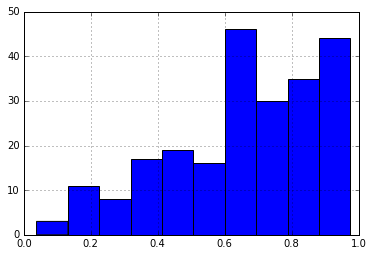

In [38]:
beatles_tracks['valence'].hist()

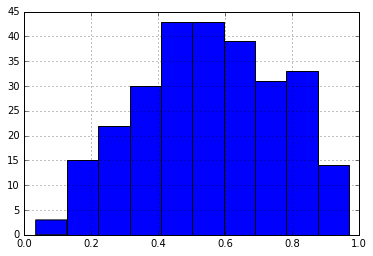

In [35]:
stones_tracks['valence'].hist()

In [31]:
tracks.find({'artist_id': stones_id, 'valence': {'$exists': True}}).count()

275

## Lyrics search<a name="lyricssearch"></a>
Now to find the lyrics for each track. 

We start by searching for the Genius ID for the artists.

Note that Genius doesn't like Python-generated requests to its API, so we set the header to pretend to be a command-line `curl` request.

* [Top](#top)

In [39]:
def genius_artist_search(artist_name, per_page=20):
    query = urllib.parse.urlencode({'q': artist_name,
                                    'per_page': str(per_page)
                                   })
    headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
    request = urllib.request.Request('https://api.genius.com/search?{}'.format(query), 
                                     headers=headers,
                                     method='GET')
    with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            return response

In [40]:
response = genius_artist_search('the beatles')
beatles_genius_id = [hit['result']['primary_artist']['id'] for hit in response['response']['hits']][0]
beatles_genius_id

586

In [41]:
response = genius_artist_search('rolling stones')
stones_genius_id = [hit['result']['primary_artist']['id'] for hit in response['response']['hits']][0]
stones_genius_id

774

We can now get the song information for each track for each artist. Note that Genius keeps lots of things to do with artists, including sleeve notes and the like. We're just after the lyrics.

In [42]:
def genius_song_search(artist_id):
    songs = pd.DataFrame()
    page = 1
    while page:
        query = urllib.parse.urlencode({'page': page, 'per_page': 20})
        headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
        request = urllib.request.Request('https://api.genius.com/artists/{id}/songs?{query}'.format(id=artist_id,
                                                                                               query=query), 
                                     headers=headers,
                                     method='GET')
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            page = response['response']['next_page']
            for song in response['response']['songs']:
                if song['path'].endswith('lyrics'):
                    song['_id'] = song['id']
                    genius_tracks.replace_one({'_id': song['id']}, song, upsert=True)

In [43]:
genius_song_search(beatles_genius_id)
genius_tracks.find().count()

1071

In [44]:
genius_song_search(stones_genius_id)
genius_tracks.find().count()

1071

In [45]:
genius_tracks.find_one()

{'_id': 1497768,
 'annotation_count': 1,
 'api_path': '/songs/1497768',
 'full_title': 'All Together on the Wireless Machine by\xa0The\xa0Beatles',
 'header_image_thumbnail_url': 'https://images.genius.com/ad1f59e8a03be4eb521e88015d15d6e8.200x200x1.jpg',
 'header_image_url': 'https://images.genius.com/ad1f59e8a03be4eb521e88015d15d6e8.200x200x1.jpg',
 'id': 1497768,
 'lyrics_owner_id': 1549345,
 'path': '/The-beatles-all-together-on-the-wireless-machine-lyrics',
 'primary_artist': {'api_path': '/artists/586',
  'header_image_url': 'https://images.genius.com/b82dbb78926a812abfa10886ac84c1a8.1000x523x1.jpg',
  'id': 586,
  'image_url': 'https://images.genius.com/ad1f59e8a03be4eb521e88015d15d6e8.200x200x1.jpg',
  'is_meme_verified': False,
  'is_verified': False,
  'name': 'The Beatles',
  'url': 'https://genius.com/artists/The-beatles'},
 'pyongs_count': None,
 'song_art_image_thumbnail_url': 'https://images.genius.com/ad1f59e8a03be4eb521e88015d15d6e8.200x200x1.jpg',
 'stats': {'hot': Fal

In [46]:
gsongs = pd.DataFrame(list(genius_tracks.find()))
gsongs.T

,0,1,2,3,4,5,6,7,8,9,...,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070
_id,1497768,210315,123533,123537,117722,210284,1336394,107915,1308579,123808,...,310483,313269,313043,2389345,1245984,311907,310293,310289,106069,310543
annotation_count,1,1,5,4,6,1,1,6,1,1,...,1,1,1,4,1,1,4,1,16,15
api_path,/songs/1497768,/songs/210315,/songs/123533,/songs/123537,/songs/117722,/songs/210284,/songs/1336394,/songs/107915,/songs/1308579,/songs/123808,...,/songs/310483,/songs/313269,/songs/313043,/songs/2389345,/songs/1245984,/songs/311907,/songs/310293,/songs/310289,/songs/106069,/songs/310543
ctitle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
full_title,All Together on the Wireless Machine by The Be...,A Little Rhyme by The Beatles (Ft. John & Rodn...,And I Love Her by The Beatles,Any Time at All by The Beatles,A Taste of Honey by The Beatles,Beatle Greetings by The Beatles (Ft. George Ha...,Can You Take Me Back by The Beatles,Carry That Weight by The Beatles,Down in Eastern Australia by The Beatles,Everybody's Trying to Be My Baby by The Beatles,...,You Can't Catch Me by The Rolling Stones,You Don't Have To Mean It by The Rolling Stones,You Got Me Rocking by The Rolling Stones,You Got the Silver by The Rolling Stones (Ft. ...,Don't Look Back by The Rolling Stones,Each and every day of the year by The Rolling ...,I'm A King Bee by The Rolling Stones,Little By Little by The Rolling Stones,Brown Sugar by The Rolling Stones,Citadel by The Rolling Stones
header_image_thumbnail_url,https://images.genius.com/ad1f59e8a03be4eb521e...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/68c11c7f5b6b66194d77...,https://images.genius.com/68c11c7f5b6b66194d77...,https://s3.amazonaws.com/rapgenius/1360709432_...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/560d707ac51a528c952d...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/4268a08d2b36372eb6e8...,...,https://images.genius.com/9c0263f14c39b6df59e5...,https://images.genius.com/eb7fd9257058b77179cb...,https://images.genius.com/a8ed1f93846da84943a7...,https://images.rapgenius.com/ac969979ccb91a0d2...,https://images.genius.com/23bbf05f7ee8286a8905...,https://images.genius.com/6c322c96140487d56076...,https://images.genius.com/076d49bcc219432b68b4...,https://images.genius.com/076d49bcc219432b68b4...,https://images.genius.com/5b7d4f11893ff2fdeba7...,https://images.genius.com/31323212a74c2a8d99eb...
header_image_url,https://images.genius.com/ad1f59e8a03be4eb521e...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/68c11c7f5b6b66194d77...,https://images.genius.com/68c11c7f5b6b66194d77...,https://s3.amazonaws.com/rapgenius/1360709432_...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/560d707ac51a528c952d...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/4268a08d2b36372eb6e8...,...,https://images.genius.com/9c0263f14c39b6df59e5...,https://images.genius.com/eb7fd9257058b77179cb...,https://images.genius.com/a8ed1f93846da84943a7...,https://images.rapgenius.com/ac969979ccb91a0d2...,https://images.genius.com/23bbf05f7ee8286a8905...,https://images.genius.com/6c322c96140487d56076...,https://images.genius.com/076d49bcc219432b68b4...,https://images.genius.com/076d49bcc219432b68b4...,https://images.genius.com/5b7d4f11893ff2fdeba7...,https://images.genius.com/31323212a74c2a8d99eb...
id,1497768,210315,123533,123537,117722,210284,1336394,107915,1308579,123808,...,310483,313269,313043,2389345,1245984,311907,310293,310289,106069,310543
lyrics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lyrics_owner_id,1549345,250962,46871,46871,70799,250962,1549345,116340,1549345,22533,...,354383,354608,354382,1217557,1549345,354385,354383,354383,16,354608


Now we can get the lyrics for each song. We tidy it up as we go, to strip out formatting and the like.

Note the use of [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to strip out the HTML from the lyrics.

In [47]:
def genius_lyrics(song_url):
    headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
    request = urllib.request.Request(song_url, headers=headers, method='GET')
    html_doc = urllib.request.urlopen(request)
    soup = BeautifulSoup(html_doc, 'html.parser')
    lyrics = soup.find('lyrics').get_text()
    l2 = re.sub('\[[^\]]*\]', '', lyrics)
    l3 = re.sub('\[|\]', '', l2)
    l4 = re.sub('(\s)+', ' ', l3)
    return l4.strip().lower(), lyrics

In [48]:
assl = genius_lyrics('https://genius.com/The-beatles-aint-she-sweet-lyrics')
assl

("oh ain't she sweet well see her walking down that street yes i ask you very confidentially ain't she sweet? oh ain't she nice well look her over once or twice yes i ask you very confidentially ain't she nice? just cast an eye in her direction oh me oh my ain't that perfection? oh i repeat well don't you think that's kind of neat? yes i ask you very confidentially ain't she sweet? oh ain't she sweet well see her walking down that street well i ask you very confidentially ain't she sweet? well i ask you very confidentially ain't she sweet?",
 "\n\n[Chorus 1]]\nOh ain't she sweet\nWell see her walking down that street\nYes I ask you very confidentially\nAin't she sweet?\n\n[Chorus 2]\nOh ain't she nice\nWell look her over once or twice\nYes I ask you very confidentially\nAin't she nice?\n\n[Chorus 3]\nJust cast an eye\nIn her direction\nOh me oh my\nAin't that perfection?\n\n[Chorus 4]\nOh I repeat\nWell don't you think that's kind of neat?\nYes I ask you very confidentially\nAin't she 

In [49]:
for gsong in genius_tracks.find():
    if 'lyrics' not in gsong:
        lyrics, original_lyrics = genius_lyrics(gsong['url'])
        genius_tracks.update_one({'_id': gsong['_id']}, 
                                 {'$set': {'lyrics': lyrics, 'original_lyrics': original_lyrics}})
genius_tracks.find_one({}, ['title', 'lyrics', 'original_lyrics'])

{'_id': 1497768,
 'lyrics': 'when i was sitting on my piano one day a magical thought came my way to write a number for the bbc kenny everett mccartney all together on the wireless machine kenny everett mccartney all together on the wireless machine kenny everett mccartney all together on the wireless machine',
 'original_lyrics': '\n\nWhen I was sitting on my piano one day\nA magical thought came my way\nTo write a number for the BBC\nKenny Everett McCartney\nAll together on the wireless machine\nKenny Everett McCartney\nAll together on the wireless machine\nKenny Everett McCartney\nAll together on the wireless machine\n\n',
 'title': 'All Together on the Wireless Machine'}

In [50]:
genius_tracks.create_index([('original_lyrics', pymongo.TEXT)])

'original_lyrics_text'

In [51]:
[t['original_lyrics'] for t in genius_tracks.find({'$text': {'$search': 'chorus'}}, limit=10)]

["\n\nClaudine's back in jail again\nClaudine's back in jail (again)\nClaudine's back in jail again\nClaudine\n\nClaudine's back in jail again\nClaudine's back in jail (again)\nShe only does it at weekends\nClaudine\nOh, Claudine\n\nNow only Spider knows for sure\nBut he ain't talkin' about it any more\nIs he, Claudine?\n\nThere's blood in the chalet\nAnd blood in the snow\n(She)Washed her hands of the whole damn show\nThe best thing you could do, Claudine\n\nShot him once right through the head\nShot him twice right through the chest\nThe judge says (ruled) it was an accident\nClaudine\nAccidents will happen\n(In the best homes)\n\nAnd Claudine's back in jail again\nClaudine's back in jail again\nClaudine's back in jail again\nClaudine\n\n(Claudine's back in jail again\nClaudine's back in jail again\nClaudine's back in jail again\n\nClaudine) (additional chorus)\nI'll tell you something\nNow Claudine's back in jail again\nClaudine's back in jail again\nClaudine's back in jail again\nC

## Matching datasets<a name="matchingdatasets"></a>
Now it's time to match up the datasets. First, we simplify the titles of the tracks, to sidestep differences in punctuation, capitalisation, and the like.

* [Top](#top)

In [8]:
def canonical_name(text):
    t1 = re.sub(' - .*', '', text) # Strip the " - Remastered 2015" suffix
    t2 = re.sub('[^\w\s]', '', t1) # strip all characters except letters, numbers, and whitespace
    t3 = re.sub('\s+', ' ', t2) # collapse whitespace
    return t3.lower() # convert to lowercase and return

In [9]:
canonical_name("A Hard Day's Night - Live / Remastered")

'a hard days night'

Add the simplified title to each track in the Spotify and Genius collections.

In [12]:
for t in tracks.find():
    tracks.update_one({'_id': t['_id']}, {'$set': {'ctitle': canonical_name(t['name'])}})
for t in genius_tracks.find():
    genius_tracks.update_one({'_id': t['_id']}, {'$set': {'ctitle': canonical_name(t['title'])}})

In [81]:
ctitles = set([t['ctitle'] for t in tracks.find()])

[(ct, [t['name'] for t in tracks.find({'ctitle': ct})]) 
 for ct in ctitles
 if tracks.find({'ctitle': ct}).count() > 1
]

[('fight', ['Fight', 'Fight - Remastered 2009']),
 ('eight days a week',
  ['Eight Days A Week - Remastered 2015',
   'Eight Days A Week - Remastered 2009']),
 ('yesterday', ['Yesterday - Remastered 2015', 'Yesterday - Remastered 2009']),
 ('had it with you', ['Had It With You', 'Had It With You - Remastered 2009']),
 ('little red rooster',
  ['Little Red Rooster - Live - 2009 Re-Mastered Digital Version',
   'Little Red Rooster - Live In Ireland / 1965']),
 ('sympathy for the devil',
  ['Sympathy For The Devil - Live At Beacon Theatre, New York / 2006',
   'Sympathy For The Devil - Live - 2009 Re-Mastered Digital Version',
   'Sympathy For The Devil - Live']),
 ('you got the silver',
  ['You Got The Silver - Live At The Beacon Theatre, New York / 2006',
   'You Got The Silver - Live']),
 ('worried about you',
  ['Worried About You - Live Licks Tour - 2009 Re-Mastered Digital Version',
   'Worried About You - 2009 Re-Mastered Digital Version']),
 ('you cant do that',
  ["You Can't Do T

In [84]:
ctitles = set([t['ctitle'] for t in tracks.find()])

[(ct, [(t['name'], t['liveness']) for t in tracks.find({'ctitle': ct, 'liveness': {'$lt': 0.7}})]) 
 for ct in ctitles
 if tracks.find({'ctitle': ct, 'liveness': {'$lt': 0.7}}).count() > 1
]

[('eight days a week',
  [('Eight Days A Week - Remastered 2015', 0.215),
   ('Eight Days A Week - Remastered 2009', 0.119)]),
 ('yesterday',
  [('Yesterday - Remastered 2015', 0.0968),
   ('Yesterday - Remastered 2009', 0.0886)]),
 ('had it with you',
  [('Had It With You', 0.0655),
   ('Had It With You - Remastered 2009', 0.0744)]),
 ('worried about you',
  [('Worried About You - Live Licks Tour - 2009 Re-Mastered Digital Version',
    0.47),
   ('Worried About You - 2009 Re-Mastered Digital Version', 0.0865)]),
 ('when the whip comes down',
  [('When The Whip Comes Down - Remastered', 0.242),
   ('When The Whip Comes Down - Remastered', 0.205)]),
 ('slipping away',
  [('Slipping Away - Live - 2009 Re-Mastered Digital Version', 0.106),
   ('Slipping Away - 2009 Re-Mastered Digital Version', 0.421)]),
 ('yellow submarine',
  [('Yellow Submarine - Remastered 2015', 0.543),
   ('Yellow Submarine - Remastered 2009', 0.528),
   ('Yellow Submarine - Remastered 2009', 0.438)]),
 ('one hit t

In [74]:
[(t['ctitle'], t['name'], g['title']) 
 for t in tracks.find()
 for g in genius_tracks.find({'ctitle': t['ctitle']})
 if genius_tracks.find({'ctitle': t['ctitle']}).count() > 1]

[('twist and shout', 'Twist And Shout - Live / Remastered', 'Twist and Shout'),
 ('twist and shout',
  'Twist And Shout - Live / Remastered',
  'Twist and shout - reloved version'),
 ('twist and shout',
  'Twist And Shout - Live / Remastered',
  'Twist And Shout - Remastered 2009'),
 ('roll over beethoven',
  'Roll Over Beethoven - Live / Remastered',
  'Roll Over Beethoven'),
 ('roll over beethoven',
  'Roll Over Beethoven - Live / Remastered',
  'Roll Over Beethoven'),
 ('she loves you', 'She Loves You - Live / Remastered', 'She Loves You'),
 ('she loves you',
  'She Loves You - Live / Remastered',
  'She loves you - reloved version'),
 ('i want to hold your hand',
  'I Want To Hold Your Hand - Live / Bonus Track',
  'I Want to Hold Your Hand'),
 ('i want to hold your hand',
  'I Want To Hold Your Hand - Live / Bonus Track',
  'I Want to Hold Your Hand'),
 ('love me do', 'Love Me Do - Mono / Remastered 2015', 'Love Me Do'),
 ('love me do',
  'Love Me Do - Mono / Remastered 2015',
  '

Now to see what the differences are. Find the tracks that are in both collections, and tracks that are in only one.

In [35]:
in_both = set((g['ctitle'], g['primary_artist']['name'])
              for g in genius_tracks.find({}, ['ctitle', 'primary_artist.name']) 
              if tracks.find({'ctitle': g['ctitle']}).count())

genius_only = set((g['ctitle'], g['primary_artist']['name']) 
                  for g in genius_tracks.find({}, ['ctitle', 'primary_artist.name']) 
                  if not tracks.find({'ctitle': g['ctitle']}).count())

spotify_only = set((s['ctitle'], s['artist_name'])
                   for s in tracks.find({}, ['ctitle', 'artist_name']) 
                   if not genius_tracks.find({'ctitle': s['ctitle']}).count())

len(in_both), len(genius_only), len(spotify_only)

(499, 563, 57)

In [36]:
[s for s in spotify_only 
 if 'rmx' not in s[0]
 if 'remix' not in s[0]
 if 'live' not in s[0]
 if 'intro' not in s[0]
]

[('bloom jamie xx rework', 'Radiohead'),
 ('sea of monsters', 'George Martin'),
 ('just my imagination', 'The Rolling Stones'),
 ('jumping jack flash', 'The Rolling Stones'),
 ('pepperland laid waste', 'George Martin'),
 ('little ta', 'The Rolling Stones'),
 ('kansas city heyheyheyhey', 'The Beatles'),
 ('bullet proof i wish i was', 'Radiohead'),
 ('sea of holes', 'George Martin'),
 ('packt like sardines in a crushed tin box', 'Radiohead'),
 ('codex illum sphere', 'Radiohead'),
 ('outro', 'Jimi Hendrix'),
 ('pepperland', 'George Martin'),
 ('key to the highway', 'The Rolling Stones'),
 ('march of the meanies', 'George Martin'),
 ('dollars cents', 'Radiohead'),
 ('little by little shed', 'Radiohead'),
 ('sea of time', 'George Martin'),
 ('faraway eyes', 'The Rolling Stones'),
 ('i will los angeles version', 'Radiohead'),
 ('everybody needs somebody to love finale', 'The Rolling Stones'),
 ('a punch up at a wedding', 'Radiohead'),
 ('revolution 1', 'The Beatles'),
 ('untitled', 'Radiohea

In [37]:
[g for g in genius_only
 if 'take' not in g[0]
 if 'medley' not in g[0]
 if 'intro' not in g[0]
 if 'live' not in g[0]
]

[('ladies and gentlemen the rolling stones', 'The Rolling Stones'),
 ('the butcher', 'Radiohead'),
 ('eds scary song', 'Radiohead'),
 ('long long while', 'The Rolling Stones'),
 ('till the next goodbye', 'The Rolling Stones'),
 ('wicked child', 'Radiohead'),
 ('bishops robes', 'Radiohead'),
 ('hey crawdaddy', 'The Rolling Stones'),
 ('baby please dont go', 'The Rolling Stones'),
 ('ready teddy', 'The Beatles'),
 ('somewhere', 'Ali brustofski'),
 ('fool to cry', 'The Rolling Stones'),
 ('john lennon vs bill oreilly', 'Nice Peter'),
 ('stray cat blues', 'The Rolling Stones'),
 ('because i know you love me so', 'The Beatles'),
 ('2120 south michigan avenue', 'The Rolling Stones'),
 ('jump on top of me', 'The Rolling Stones'),
 ('cinnamon girl', 'Radiohead'),
 ('john wesley harding', 'The Rolling Stones'),
 ('the honeymoon song', 'The Beatles'),
 ('dont ever change', 'The Beatles'),
 ('mantua', 'Radiohead'),
 ('fanny mae', 'The Rolling Stones'),
 ('paint it blacker', 'Plan B'),
 ('i froze 

In [38]:
[t for t in genius_only if 'revolution' in t[0]]

[('revolution', 'The Beatles'), ('revolution i', 'The Beatles')]

In [39]:
[t for t in spotify_only if 'revolution' in t[0]]

[('revolution 1', 'The Beatles')]

In [40]:
([t for t in in_both if 'jack flash' in t], [t for t in spotify_only if 'jack flash' in t[0]])

([], [('jumping jack flash', 'The Rolling Stones')])

In [42]:
for ct in ctitles:
    sts = [(t['ctitle'], t['artist_name']) for t in tracks.find({'ctitle': ct}, ['ctitle', 'artist_name'])]
    gts = [(t['ctitle'], t['primary_artist']['name']) for t in genius_tracks.find({'ctitle': ct}, ['ctitle', 'primary_artist.name'])]
    if len(sts) != 1 or len(gts) != 1:
        print(ct, sts, gts)

i might be wrong live [('i might be wrong live', 'Radiohead')] []
losing my touch [] [('losing my touch', 'The Rolling Stones')]
burning bush [] [('burning bush', 'Radiohead')]
just a rumour [] [('just a rumour', 'The Beatles')]
eight days a week [('eight days a week', 'The Beatles'), ('eight days a week', 'The Beatles')] [('eight days a week', 'The Beatles')]
little by little caribou rmx [('little by little caribou rmx', 'Radiohead')] []
yesterdays papers [] [('yesterdays papers', 'The Rolling Stones')]
con le mie lacrime [] [('con le mie lacrime', 'The Rolling Stones')]
come on [] [('come on', 'The Rolling Stones')]
fortune teller [] [('fortune teller', 'The Rolling Stones')]
cinnamon girl [] [('cinnamon girl', 'Radiohead')]
lewis mistreated [] [('lewis mistreated', 'Radiohead')]
bright lights big city [] [('bright lights big city', 'The Rolling Stones')]
johnny b goode [] [('johnny b goode', 'The Beatles')]
give it up [] [('give it up', 'On A Friday')]
crinsk dee night [] [('crinsk 

the daily mail [] [('the daily mail', 'Radiohead')]
try a little harder [] [('try a little harder', 'The Rolling Stones')]
bishops robes [] [('bishops robes', 'Radiohead')]
casino boogie [] [('casino boogie', 'The Rolling Stones')]
fool to cry [] [('fool to cry', 'The Rolling Stones')]
outro [('outro', 'Jimi Hendrix')] []
i will [('i will', 'The Beatles'), ('i will', 'Radiohead')] [('i will', 'Radiohead'), ('i will', 'The Beatles')]
the fool on the hill demo [] [('the fool on the hill demo', 'The Beatles')]
yes it is [] [('yes it is', 'The Beatles')]
the butcher [] [('the butcher', 'Radiohead')]
blood red wine [] [('blood red wine', 'The Rolling Stones')]
youll be mine [] [('youll be mine', 'The Beatles')]
luxury [] [('luxury', 'The Rolling Stones')]
tell me youre coming back [] [('tell me youre coming back', 'The Rolling Stones')]
paint it black [('paint it black', 'The Rolling Stones'), ('paint it black', 'The Rolling Stones'), ('paint it black', 'The Rolling Stones'), ('paint it bla

good times [] [('good times', 'The Rolling Stones')]
meeting in the aisle [] [('meeting in the aisle', 'Radiohead')]
lozenge of love [] [('lozenge of love', 'Radiohead')]
hitch hike [] [('hitch hike', 'The Rolling Stones')]
to be a brilliant light [] [('to be a brilliant light', 'On A Friday')]
separator anstam rmx [('separator anstam rmx', 'Radiohead')] []
doo doo doo doo doo heartbreaker [] [('doo doo doo doo doo heartbreaker', 'The Rolling Stones')]
beast of burden [('beast of burden', 'The Rolling Stones'), ('beast of burden', 'The Rolling Stones'), ('beast of burden', 'The Rolling Stones')] [('beast of burden', 'The Rolling Stones')]
medley kansas cityhey hey hey hey [] [('medley kansas cityhey hey hey hey', 'The Beatles')]
bloom objekt rmx [('bloom objekt rmx', 'Radiohead')] []
intro take the a train [('intro take the a train', 'Duke Ellington')] []
money thats what i want [('money thats what i want', 'The Beatles')] [('money thats what i want', 'The Beatles'), ('money thats what

sea of monsters [('sea of monsters', 'George Martin')] []
3 [] [('3', 'The Rolling Stones')]
linda lu [] [('linda lu', 'The Rolling Stones')]
please go home [] [('please go home', 'The Rolling Stones')]
tell me why ep [] [('tell me why ep', 'The Beatles')]
fight [('fight', 'The Rolling Stones'), ('fight', 'The Rolling Stones')] [('fight', 'The Rolling Stones')]
goodbye [] [('goodbye', 'The Beatles')]
mr b [] [('mr b', 'Radiohead')]
jerusalem [] [('jerusalem', 'On A Friday')]
bye bye johnny [] [('bye bye johnny', 'The Rolling Stones')]
india [] [('india', 'The Beatles')]
eds scary song [] [('eds scary song', 'Radiohead')]
beautiful delilah [] [('beautiful delilah', 'The Rolling Stones')]
upside down [] [('upside down', 'Radiohead')]
hello little girl [] [('hello little girl', 'The Beatles')]
meet me in the bottom [] [('meet me in the bottom', 'The Rolling Stones')]
feral lone rmx [('feral lone rmx', 'Radiohead')] []
aint she sweet [] [('aint she sweet', 'The Beatles')]
harlem shuffle ny

sittin on a fence [] [('sittin on a fence', 'The Rolling Stones')]
pass the wine sophia loren [] [('pass the wine sophia loren', 'The Rolling Stones')]
grown up wrong [] [('grown up wrong', 'The Rolling Stones')]
think [] [('think', 'The Rolling Stones')]
idioteque live in oxford [('idioteque live in oxford', 'Radiohead')] []
sour milk sea [] [('sour milk sea', 'The Beatles')]
killer cars [] [('killer cars', 'Radiohead')]
tell me [] [('tell me', 'The Rolling Stones')]
sie liebt dich [] [('sie liebt dich', 'The Beatles')]
movie medley [] [('movie medley', 'The Beatles')]
one more try [] [('one more try', 'The Rolling Stones')]
tkol altrice rmx [('tkol altrice rmx', 'Radiohead')] []
mannish boy [] [('mannish boy', 'The Rolling Stones')]
commonwealth [] [('commonwealth', 'The Beatles')]
ceremony [] [('ceremony', 'Radiohead')]
dance little sister [] [('dance little sister', 'The Rolling Stones')]
i call your name [] [('i call your name', 'The Beatles')]
sing this all together see what happ

cry for a shadow [] [('cry for a shadow', 'The Beatles')]
wicked child [] [('wicked child', 'Radiohead')]
like dreamers do [] [('like dreamers do', 'The Beatles')]
step inside love [] [('step inside love', 'The Beatles')]
sad day [] [('sad day', 'The Rolling Stones')]
talkin about you [] [('talkin about you', 'The Rolling Stones')]
faithless the wonderboy [] [('faithless the wonderboy', 'Radiohead')]
dancing with mr d [] [('dancing with mr d', 'The Rolling Stones')]
im going down [] [('im going down', 'The Rolling Stones')]
who am i [] [('who am i', 'The Rolling Stones')]
untitled [('untitled', 'Radiohead')] []
we are wasting time [] [('we are wasting time', 'The Rolling Stones')]
moonlight bay [] [('moonlight bay', 'The Beatles')]
eleanor rigby [('eleanor rigby', 'The Beatles'), ('eleanor rigby', 'The Beatles')] [('eleanor rigby', 'The Beatles')]
pain in my heart [('pain in my heart', 'The Rolling Stones')] [('pain in my heart', 'The Rolling Stones'), ('pain in my heart', 'The Rolling

In [44]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

In [76]:
banned_substrings = ['rmx', 'remix', 'rework', 'live', 'intro', 'medley']
genius_and_both = genius_only | in_both
for s in spotify_only:
    if not any(banned in s[0] for banned in banned_substrings):
        candidates = [g for g in genius_and_both if g[1] == s[1]]
        if candidates:
            gt = min(candidates, key=lambda g: levenshtein(s[0], g[0]))
            d = levenshtein(s[0], gt[0])
        else:
            gt = 'Missing'
            d = 99999
        print(s, gt, d, gt in in_both)

('sea of monsters', 'George Martin') ('yellow submarine in pepperland', 'George Martin') 23 True
('just my imagination', 'The Rolling Stones') ('out of control', 'The Rolling Stones') 12 True
('jumping jack flash', 'The Rolling Stones') ('jumpin jack flash', 'The Rolling Stones') 1 True
('pepperland laid waste', 'George Martin') ('yellow submarine in pepperland', 'George Martin') 25 True
('little ta', 'The Rolling Stones') ('little t a', 'The Rolling Stones') 1 False
('kansas city heyheyheyhey', 'The Beatles') ('medley kansas cityhey hey hey hey', 'The Beatles') 11 False
('bullet proof i wish i was', 'Radiohead') ('bullet proofi wish i was', 'Radiohead') 1 False
('sea of holes', 'George Martin') ('yellow submarine in pepperland', 'George Martin') 25 True
('packt like sardines in a crushed tin box', 'Radiohead') ('packt like sardines in a crushd tin box', 'Radiohead') 1 False
('codex illum sphere', 'Radiohead') ('the butcher', 'Radiohead') 12 False
('outro', 'Jimi Hendrix') Missing 9999

In [52]:
genius_and_both = genius_only | in_both
for s in spotify_only:
    if 'rmx' not in s[0] and 'remix' not in s[0] and 'live' not in s[0]:
        album = 
        candidates = [g for g in genius_and_both if g[1] == s[1]]
        if candidates:
            gts = [(g, levenshtein(s[0], g[0])) for g in candidates if levenshtein(s[0], g[0]) < 5]
            print(s, gts)

('charlies intro to little red rooster', 'The Rolling Stones') []
('bloom jamie xx rework', 'Radiohead') []
('sea of monsters', 'George Martin') []
('just my imagination', 'The Rolling Stones') []
('jumping jack flash', 'The Rolling Stones') [(('jumpin jack flash', 'The Rolling Stones'), 1)]
('pepperland laid waste', 'George Martin') []
('little ta', 'The Rolling Stones') [(('title 5', 'The Rolling Stones'), 4), (('little t a', 'The Rolling Stones'), 1), (('little rain', 'The Rolling Stones'), 3), (('little baby', 'The Rolling Stones'), 3)]
('kansas city heyheyheyhey', 'The Beatles') []
('bullet proof i wish i was', 'Radiohead') [(('bullet proofi wish i was', 'Radiohead'), 1)]
('sea of holes', 'George Martin') []
('packt like sardines in a crushed tin box', 'Radiohead') [(('packt like sardines in a crushd tin box', 'Radiohead'), 1)]
('codex illum sphere', 'Radiohead') []
('pepperland', 'George Martin') []
('key to the highway', 'The Rolling Stones') []
('march of the meanies', 'George 

In [54]:
pd.DataFrame(list(albums.find({}, ['artist_name', 'name'])))

,_id,artist_name,name
0,5XfJmldgWzrc1AIdbBaVZn,The Beatles,Live At The Hollywood Bowl
1,5ju5Ouzan3QwXqQt1Tihbh,The Beatles,1 (Remastered)
2,2pCqZLeavM2BMovJXsJEIV,The Beatles,Let It Be (Remastered)
3,2Pqkn9Dq2DFtdfkKAeqgMd,The Beatles,Abbey Road (Remastered)
4,47bcKzmKgmMPHXNVOWpLiu,The Beatles,Yellow Submarine (Remastered)
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered)
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered)
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered)
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered)


Manually fix a couple of errors.

In [85]:
genius_tracks.update_many({'ctitle': 'revolution i'}, 
                          {'$set': {'ctitle': 'revolution 1'}})
genius_tracks.update_many({'ctitle': 'when im sixtyfour'}, 
                          {'$set': {'ctitle': 'when im sixty four'}})
genius_tracks.update_many({'ctitle': 'packt like sardines in a crushd tin box'}, 
                          {'$set': {'ctitle': 'packt like sardines in a crushed tin box'}})
genius_tracks.update_many({'ctitle': 'a punchup at a wedding'}, 
                          {'$set': {'ctitle': 'a punch up at a wedding'}})
genius_tracks.update_many({'ctitle': 'dollars cents'}, 
                          {'$set': {'ctitle': 'dollars and cents'}})
genius_tracks.update_many({'ctitle': 'bullet proofi wish i was'}, 
                          {'$set': {'ctitle': 'bullet proof i wish i was'}})
genius_tracks.update_many({'ctitle': 'jumpin jack flash'}, 
                          {'$set': {'ctitle': 'jumping jack flash'}})
genius_tracks.update_many({'ctitle': 'far away eyes'}, 
                          {'$set': {'ctitle': 'faraway eyes'}})

In [86]:
in_both = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if tracks.find({'ctitle': g['ctitle']}).count())
genius_only = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if not tracks.find({'ctitle': g['ctitle']}).count())
spotify_only = set(s['ctitle'] for s in tracks.find({}, ['ctitle']) if not genius_tracks.find({'ctitle': s['ctitle']}).count())
len(in_both), len(genius_only), len(spotify_only)

(494, 554, 52)

### Copy the lyrics over<a name="copylyrics"></a>
Now can can connect the tracks, let's copy across the lyrics from the Genius collection into the Spotify collection. We'll calculate the lyrical density at the same time.

* [Top](#top)

In [87]:
for t in tracks.find({}, ['ctitle', 'duration_ms']):
    gts = genius_tracks.find({'ctitle': t['ctitle'], 'lyrics': {'$exists': True}}, ['lyrics', 'original_lyrics'])
    for gt in gts:
        tracks.update_one({'_id': t['_id']}, 
                          {'$set': {'lyrics': gt['lyrics'], 
                                    'original_lyrics': gt['original_lyrics'],
                                    'lyrical_density': 1000 * len(gt['lyrics'].split()) / t['duration_ms']}})

## Sentiment analysis<a name="sentimentanalysis"></a>
I couldn't find an easily-installable equivalent to the NRC corpus, so I'm using a sentiment analysis API endpoint from [Text Processing](http://text-processing.com/docs/sentiment.html).

* [Top](#top)

In [88]:
for t in tracks.find({'lyrics': {'$exists': True}}, ['lyrics']):
    text = t['lyrics']
    if text:
        query = urllib.parse.urlencode({'text': text}).encode('ascii')
        headers = {'Accept': 'application/json',
                   'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
        request = urllib.request.Request('http://text-processing.com/api/sentiment/', 
                                 headers=headers, data=query)
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            tracks.update_one({'_id': t['_id']}, {'$set': {'sentiment': response}})

In [89]:
tracks.find_one({'sentiment': {'$exists': True}}).keys()

dict_keys(['track_number', 'time_signature', '_id', 'preview_url', 'sentiment', 'loudness', 'type', 'external_ids', 'uri', 'album_id', 'lyrics', 'lyrical_density', 'tempo', 'danceability', 'href', 'disc_number', 'available_markets', 'analysis_url', 'instrumentalness', 'artist_id', 'name', 'id', 'valence', 'external_urls', 'ctitle', 'track_href', 'duration_ms', 'artist_name', 'explicit', 'speechiness', 'artists', 'album', 'key', 'original_lyrics', 'popularity', 'acousticness', 'liveness', 'mode', 'energy'])

In [90]:
tracks.find_one({'sentiment': {'$exists': True}})

{'_id': '74tlMxJ8wF0sNp93GBEPdK',
 'acousticness': 0.00352,
 'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/22bE4uQ6baNwSHPVcDxLCe'},
    'href': 'https://api.spotify.com/v1/artists/22bE4uQ6baNwSHPVcDxLCe',
    'id': '22bE4uQ6baNwSHPVcDxLCe',
    'name': 'The Rolling Stones',
    'type': 'artist',
    'uri': 'spotify:artist:22bE4uQ6baNwSHPVcDxLCe'}],
  'available_markets': ['GB'],
  'external_urls': {'spotify': 'https://open.spotify.com/album/3PbRKFafwE7Of8e4dTee72'},
  'href': 'https://api.spotify.com/v1/albums/3PbRKFafwE7Of8e4dTee72',
  'id': '3PbRKFafwE7Of8e4dTee72',
  'images': [{'height': 640,
    'url': 'https://i.scdn.co/image/4bd988736fe53e8109488f0f390cdfd5d119762d',
    'width': 640},
   {'height': 300,
    'url': 'https://i.scdn.co/image/b5c53642ccdaac3120aa766ce5e29d9c1b61794f',
    'width': 300},
   {'height': 64,
    'url': 'https://i.scdn.co/image/9c6e2872cbd2688c528d5d43c57651d12c19eec1',
    'width': 64}],


In [91]:
tracks.find({'sentiment': {'$exists': True}}).count(), tracks.find({'sentiment': {'$exists': False}}).count()

(606, 65)

In [92]:
tracks.find({'sentiment': {'$exists': False}, 'lyrics': {'$exists': True}}).count()

8

In [97]:
pd.DataFrame(list(tracks.find({'sentiment': {'$exists': False}, 
                               'lyrics': {'$exists': True}}, 
                              ['name', 'artist_name', 'lyrics'])))

,_id,artist_name,lyrics,name
0,47DgFAFnhfwoSko23P7pz5,George Martin,,Yellow Submarine In Pepperland - Remastered 2009
1,2z1p43SNSbeowzy8WdYHNk,The Beatles,,Flying - Remastered 2009
2,3gKuywOm38axM8sJGq6Laq,Radiohead,,MK 1
3,2uYSbsxAMmK1awUl06T7ix,Radiohead,,MK 2
4,1q6X5sJSWQ2QnqvPghR0Kr,Radiohead,,I Am Citizen Insane
5,4blz5SBUxKbtDNwMWstGNG,Radiohead,,Where Bluebirds Fly
6,2zYrFer4QGSQkk5aUawfHB,Radiohead,,Hunting Bears
7,4DPQvbgSM0IdX4O3HOACwL,Radiohead,,Treefingers


In [99]:
list(tracks.find({'sentiment': {'$exists': False}, 
                               'lyrics': {'$exists': True}}, 
                              ['name', 'artist_name', 'lyrics', 'original_lyrics']))

[{'_id': '47DgFAFnhfwoSko23P7pz5',
  'artist_name': 'George Martin',
  'lyrics': '',
  'name': 'Yellow Submarine In Pepperland - Remastered 2009',
  'original_lyrics': '\n\n[Instrumental]\n\n'},
 {'_id': '2z1p43SNSbeowzy8WdYHNk',
  'artist_name': 'The Beatles',
  'lyrics': '',
  'name': 'Flying - Remastered 2009',
  'original_lyrics': '\n\n[Instrumental]\n\n'},
 {'_id': '3gKuywOm38axM8sJGq6Laq',
  'artist_name': 'Radiohead',
  'lyrics': '',
  'name': 'MK 1',
  'original_lyrics': '\n\n[Instrumental]\n\n'},
 {'_id': '2uYSbsxAMmK1awUl06T7ix',
  'artist_name': 'Radiohead',
  'lyrics': '',
  'name': 'MK 2',
  'original_lyrics': '\n\n[Instrumental]\n\n'},
 {'_id': '1q6X5sJSWQ2QnqvPghR0Kr',
  'artist_name': 'Radiohead',
  'lyrics': '',
  'name': 'I Am Citizen Insane',
  'original_lyrics': '\n\n[Instrumental]\n\n'},
 {'_id': '4blz5SBUxKbtDNwMWstGNG',
  'artist_name': 'Radiohead',
  'lyrics': '',
  'name': 'Where Bluebirds Fly',
  'original_lyrics': '\n\n[Distorted "Somewhere Over The Rainbow" 

In [101]:
tracks.update_many({'lyrics': ''}, {'$unset': {'lyrics': ''}})

In [102]:
pd.DataFrame(list(tracks.find({'sentiment': {'$exists': False}, 
                               'lyrics': {'$exists': True}}, 
                              ['name', 'artist_name', 'lyrics'])))

""
